# Final CHO Model
This notebook is to asses the validity of our reconstruction and how complete it is.

[1. Generation of the dataset and model reconstruction](#generation) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.1 Retrieve information from the Google Sheet datasets reactions and metabolites**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.2 Build a model and feed it the information from the df generated** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.3 Save and validate the model** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.4 Check for unbalanced reactions** <br>

[2. Identification of Blocked Reactions and Dead-End Metabolites](#blocked&deadends) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**2.1 Identification of Blocked Reactions**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**2.2 Identification of Dead-Ends Metabolites** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**2.3 Addition of Extracellular Exchange Reanctions** <br>

[3. Generation of the Mass Flow Graph](#MFG) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.1 Generation of the "D-Matrix"**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.2 Plotting the "D-Matrix", Normalized Flow Graph (NFG)** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.3 Generation of the "FluxOpenValue" matrix** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.4 Generation of the "Mass Flow Graph (MFG) Matrix"** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.5 Plotting the "MFG Matrix"** <br>

[4. Identification of duplicates through Chemical Formulas](#formulas) <br>

## 1. Generation of the dataset and model reconstruction <a id='generation'></a>
Here we generate the CHO model from the dataset stored in the Google Sheet file. We first use the google_sheet module to extract all the necessary information from the original dataset. Then we use those dataset and the COBRApy library to: (1) Create a new model and add reactions from the **Rxns Sheet**, (2) Add information on each reaction obtained from the **Rxns Sheet** and **Attributes Sheet**, (3) Add boundary reactions from the **BoundaryRxns Sheet**, and (4) Add information for each metabolite from the **Metabolites Sheet**. Finally we save the model as a SBML file and validate it using the cobrapy built-in function "validate_sbml_model( )".

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime

import cobra
from cobra import Model, Reaction, Metabolite
from cobra.io import validate_sbml_model, save_json_model, write_sbml_model

from tqdm.notebook import tqdm

from google_sheet import GoogleSheet

### 1.1 Retrieve information from the Google Sheet datasets reactions and metabolites

In [ ]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
SPREADSHEET_ID = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_met = 'Metabolites'
sheet_rxns = 'Rxns'
sheet_attributes = 'Attributes'
sheet_boundary = 'BoundaryRxns'

metabolites = sheet.read_google_sheet(sheet_met)
rxns = sheet.read_google_sheet(sheet_rxns)
rxns_attributes = sheet.read_google_sheet(sheet_attributes)
boundary_rxns = sheet.read_google_sheet(sheet_boundary)

### 1.2 Build a model and feed it the information from the df generated

In [ ]:
##### ----- Create a model and add reactions ----- #####
model = Model("iCHO")
lr = []
for _, row in rxns.iterrows():
    r = Reaction(row['Reaction'])
    lr.append(r)    
model.add_reactions(lr)

In [ ]:
##### ----- Add information to each one of the reactions ----- #####
for i,r in enumerate(tqdm(model.reactions)):    
    r.build_reaction_from_string(rxns['Reaction Formula'][i])
    r.name = rxns['Reaction Name'][i]
    r.subsystem = rxns['Subsystem'][i]
    r.gene_reaction_rule = str(rxns['GPR_final'][i])
    r.lower_bound = float(rxns_attributes['Lower bound'][i])
    r.upper_bound = float(rxns_attributes['Upper bound'][i])

In [ ]:
##### ----- Add Boundary Reactions ----- #####
dr = []
for _, row in boundary_rxns.iterrows():
    r = Reaction(row['Reaction'])
    dr.append(r)    
model.add_reactions(dr)

boundary_rxns_dict = boundary_rxns.set_index('Reaction').to_dict()
boundary_rxns_dict

for i,r in enumerate(tqdm(model.reactions)):
    if r in dr:
        r.build_reaction_from_string(boundary_rxns_dict['Reaction Formula'][r.id])
        r.name = boundary_rxns_dict['Reaction Name'][r.id]
        r.subsystem = boundary_rxns_dict['Subsystem'][r.id]
        r.lower_bound = float(boundary_rxns_dict['Lower bound'][r.id])
        r.upper_bound = float(boundary_rxns_dict['Upper bound'][r.id]) 
model

In [ ]:
##### ----- Add information for each metabolite ----- #####
metabolites_dict = metabolites.set_index('BiGG ID').to_dict('dict')
metabolites_dict['Name']
for met in model.metabolites:
    met.name = metabolites_dict['Name'][f'{met}']
    met.formula = metabolites_dict['Formula'][f'{met}']
    met.compartment = metabolites_dict['Compartment'][f'{met}'].split(' - ')[0]
    try:
        met.charge = int(metabolites_dict['Charge'][f'{met}'])
    except (ValueError, TypeError):
        print(f'{met} doesnt have charge')

### 1.3 Save and validate the model

In [ ]:
##### ----- Build the S matrix ----- #####
S = cobra.util.create_stoichiometric_matrix(model, array_type='dense')
model.S = S

model.objective = 'biomass_cho'
model.optimize()

In [ ]:
##### ----- Save the model ----- #####
model_name_xml = 'iCHOv3_CHO_'+datetime.now().strftime("%d%m%Y")+'.xml' 
write_sbml_model(model, model_name_xml)

# Write in json because, the sbml doesnt savve the subsystems
model_name_json = 'iCHOv3_CHO_'+datetime.now().strftime("%d%m%Y")+'.json' 
save_json_model(model, model_name_json)

In [ ]:
##### ----- Test for errors in the recostruction ----- ######

# import tempfile
# from pprint import pprint
# from cobra.io import write_sbml_model, validate_sbml_model
# with tempfile.NamedTemporaryFile(suffix='.xml') as f_sbml:
#     write_sbml_model(model, filename=f_sbml.name)
#     report = validate_sbml_model(filename=f_sbml.name)
# pprint(report)

from cobra.io import read_sbml_model, validate_sbml_model
(_, errors) = validate_sbml_model(model_name_xml)
errors

### 1.4 Check for unbalanced reactions
Once the model is checked and saved as a xml and json format we then evaluate the amount of mass and charge unbalanced reactions

In [ ]:
# Check for unbalanced reactions
subsystems = ['BIOMASS SYNTHESIS', 'PROTEIN ASSEMBLY', 'PROTEIN DEGRADATION'] # filter out the reactions from these subsystems

# Lists to store the data for each column
reaction_ids = []
formulas = []
metabolites = []
unbalances = []

counter = 0
for rxn in model.reactions:
    if not rxn.id.startswith(('EX_','DM_','SK_')) and rxn.subsystem not in subsystems:
        mb = rxn.check_mass_balance()
        if mb != {}:# and set(mb.keys()) != {'charge'}:  # Check if dictionary has keys other than 'charge'
            counter+=1
            prod_ids = [{met.id:met.formula} for met in rxn.products]
            react_ids = [{met.id:met.formula} for met in rxn.reactants]
            # Append values to lists
            print(rxn.id)
            reaction_ids.append(rxn.id)
            print(rxn.reaction)
            formulas.append(rxn.reaction)
            print(react_ids + prod_ids)
            metabolites.append(react_ids + prod_ids)
            print(mb)
            unbalances.append(mb)
            print('...............................')
print(counter)

# Create DataFrame from lists
mass_unbalanced_reactions = pd.DataFrame({
    "Reaction ID": reaction_ids,
    "Formula": formulas,
    "Metabolites": metabolites,
    "Unbalance": unbalances
})

mass_unbalanced_reactions.to_excel("mass_unbalanced_reactions.xlsx", engine='openpyxl', index=False)

In [ ]:
# Update the "Balance status" column based on whether the reaction is present in "reaction_ids"
rxns_copy = rxns.copy()
rxns_copy['Balance status'] = rxns_copy['Reaction'].apply(lambda x: 'UNBALANCED' if x in reaction_ids else 'BALANCED')
rxns_equals = rxns_copy.equals(rxns)

In [ ]:
##############################################
#### ------------------------------------ ####
#### ---- Update Rxns Google Sheets ----- ####
#### ------------------------------------ ####
##############################################
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, rxns_copy)
    print("Google Sheet updated.")

## 2. Identification of Blocked Reactions and Dead-End Metabolites <a id='blocked&deadends'></a>
In this second part of the notebook we use two different functions from the utils module to: (1) Run a flux variability analysis and identify blocked reactions, and (2) identify dead-end metabolites. Finally we add Extracellular Exchange reactions for the dead-end metabolites that are in the extracellular compartment.

In [ ]:
import pandas as pd
from cobra.io import read_sbml_model
from cobra.flux_analysis import find_blocked_reactions
from utils import detect_dead_ends

In [ ]:
##### ----- Read Model ----- #####
if 'model' not in locals():
    model = read_sbml_model("iCHOv3_CHO_11102023.xml")
    print('Model loaded')
else:
    print('Model already generated')

### 2.1 Identification of Blocked Reactions
The runMinMax_Single( ) function from the utils module runs an FVA (flux variability analysis) to find the ranges of each reaction's metabolic flux at the optimum. The results are stored in the "FVA_Results.txt" file with all the reactions IDs and its respective fluxes. Reactions with no flux (**Blocked Reactions**) are stored in another file called "Blocked_Reactions.txt"

In [ ]:
##### ----- FVA ----- #####
import utils

model.solver = 'gurobi'


#for rxn_exchange in model.exchanges:
#    rxn_exchange.bounds = (-1000, 1000)
#minmax = utils.runMinMax_Single(model, end_rxn_index=None)


##### Create DataFrame and Save to CSV #####
# Create a list to store data
data = []

# Populate the data list
for i, j in enumerate(minmax):
    data.append({'Reaction': model.reactions[i].id, 'Min': j[0], 'Max': j[1]})

# Create a DataFrame from the data list
fva_results = pd.DataFrame(data)

# Save the DataFrame to a CSV file
fva_results.to_csv('temp/FVA_Results.csv', index=False)

##### Save Blocked Reactions to CSV #####
# Filter the DataFrame to only include blocked reactions
blocked_reactions = fva_results[(fva_results['Min'] == 0) & (fva_results['Max'] == 0)]

# Save the filtered DataFrame to a CSV file
blocked_reactions.to_csv('temp/Blocked_Reactions.csv', index=False)

In [ ]:
##### ----- Blocked Reactions ----- #####
model.solver = 'gurobi'
blocked_reactions = find_blocked_reactions(model)

print(blocked_reactions)

In [ ]:
##### ----- Print the amount  and % of blocked reactions ----- #####
print('##### ----- Blocked Reactions ----- #####')
print(f'The model has {len(model.reactions)} total reactions')
print(f'The model has {len(blocked_reactions)} ({round(len(blocked_reactions)/len(model.reactions)*100)}%) blocked reactions')

### 2.2 Identification of Dead-Ends Metabolites
The detect_dead_ends( ) function from the utils module returns a list with all the **dead-end** metabolites in our model. A dead-end metabolite refers to a metabolite that is either only consumed but not produced, or only produced but not consumed, in a given metabolic network. The results are stored in the "Dead-ends.txt" file.

In [ ]:
##### ----- Detect Dead-Ends ----- #####
model.solver = 'gurobi' #change 'gurobi' for the default cobrapy solver 'glpk' 
dead_ends = detect_dead_ends(model)


with open('Dead_ends.txt', 'w') as f:
    for i,j in enumerate(dead_ends):
        if j:
            print(model.metabolites[i], file=f)
            
rxn_c = 0
met_c = 0
for i,j in enumerate(dead_ends):
    if j:
        met_c += 1
        print("\n", model.metabolites[i],": ")
        for met_rxn in model.metabolites[i].reactions:
            rxn_c += 1
            print(met_rxn)
            print(rxn_c)

print(f'Percentage of Dead-End metabolites is {round(met_c/len(model.metabolites)*100)}%' )

### 2.3 Addition of Extracellular Exchange Reanctions
The following cell adds **EXTRACELLULAR EXCHANGE** reactions to the dead-end metabolites in the extracellular compartment from the list generated above.

In [ ]:
##### ----- Automatically add EXTRACELLULAR EXCHANGE reactions to the "BoundaryRxns" Sheet ----- #####
added_exchange = False
for i,j in enumerate(dead_ends):
    if j:
        if str(model.metabolites[i]).endswith('_e'):
            new_row_data = {'Curated': '', 'Reaction': 'EX_'+str(model.metabolites[i]), 'Reaction Name': 'Exchange of '+model.metabolites[i].name, 'Reaction Formula': str(model.metabolites[i])+' <=>', 'Subsystem': 'EXTRACELLULAR EXCHANGE',
                                    'Reversible': 1, 'Lower bound': -1000, 'Upper bound': 1000, 'Objective': 0}
            new_row_df = pd.DataFrame(new_row_data, index=[len(boundary_rxns)])
            boundary_rxns = pd.concat([boundary_rxns, new_row_df])
            added_exchange = True

#Check for duplicated reactions added to the boundary_rxns dataset, IF NOT: update the google sheet file
if added_exchange:
    if not boundary_rxns['Reaction'].duplicated().any() and not boundary_rxns['Reaction Formula'].duplicated().any():
        sheet.update_google_sheet(sheet_boundary, boundary_rxns)
        print("BoundaryRxns Google Sheet updated.")
    else:
        print('Duplicated values found in the dataset')

### 2.4 Gapfill for blocked reactions
Cobrapy has a gap filling implementation that is very similar to that of Reed et al. where we use a mixed-integer linear program to figure out the smallest number of reactions that need to be added for a user-defined collection of reactions, i.e. a universal model.

In [ ]:
import cobra
from cobra.flux_analysis import gapfill

#recon_3d = read_sbml_model("../Data/GPR_curation/Recon3D.xml")
#iCHO2291 = read_sbml_model("../Data/Reconciliation/models/iCHO2291.xml")
#universal = recon_3d.merge(iCHO2291)

In [ ]:
for blocked_reaction in blocked:
    model.objective = blocked_reaction
    model.optimize().objective_value
    try:
        solution = gapfill(model, iCHO2291, demand_reactions=True)
        print(blocked_reaction)
        print(solution)
    except Exception as e:
        print(f'Gapfill failed for {blocked_reaction}: {str(e)}')
        continue

### Test CHO - Recon GEM

In [ ]:
universal

In [ ]:
# iCHO_recon3dfrom cobra.io import read_sbml_model
# read_sbml_model(".xml")

model_EX = [i for i, rxn in enumerate(model.reactions) if 'EX_' in rxn.id]
model_SK = [i for i, rxn in enumerate(model.reactions) if 'SK_' in rxn.id]
model_DM = [i for i, rxn in enumerate(model.reactions) if 'DM_' in rxn.id]
for i in model_EX:
    model.reactions[i].bounds = -1000, 1000

for i in model_SK:
    model.reactions[i].bounds = -1000, 1000

for i in model_DM:
    model.reactions[i].bounds = 0, 1000
    

In [ ]:
model.objective = "biomass_cho" # 
sol1 = model.optimize()
print(sol1.objective_value)

model.objective = "biomass_cho_prod" # 
sol2 = model.optimize()
print(sol2.objective_value)

In [ ]:
##### ----- Test model KOs ----- #####
for reaction in model.reactions:
    with model as model:
        reaction.knock_out()
        model.optimize()
        print('%s blocked (bounds: %s), new growth rate %f' %
              (reaction.id, str(reaction.bounds), model.objective.value))

## 3. Generation of the Mass Flow Graph <a id='MFG'></a>
Based on the publication **_Flux-dependent graphs for metabolic networks_** by _Beguerisse-Diaz et al. (2018)_ (https://www.nature.com/articles/s41540-018-0067-y). Here we use our model to build the **D Matrix** and plot the corresponding graph, then the **M Matrix** and plot the corresponding graph, and finally we generate the **PageRank** file with all the reactions in our reconstruction sorted by importance.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import networkx as nx
from scipy.linalg import pinv

import time

from skimage import draw
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

import cobra
from cobra.io import load_json_model

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [14]:
##### ----- Read Model ----- #####
if 'model' not in locals():
    model = load_json_model("iCHOv3_CHO_02112023.json")
    print('model loaded')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-24
model loaded


### 3.1 Generation of the "D-Matrix"
The "D-Matrix" defines the weight of the edge between reaction nodes Ri and Rj as the probability that any metabolite chosen at random is produced by Ri (reaction i) and consumed by Rj (reaction j). Summing over all metabolites and normalizing, we obtain the edge weights of the adjacency matrix of the NFG:

In [ ]:
# Extract stoichiometric matrix, m=reactions, n=metabolites
start = time.time()
S = cobra.util.array.create_stoichiometric_matrix(model)
n, m = S.shape
end = time.time()
print(f"Time taken to generate S, n and m: {end - start} seconds")

# Create S2m matrix
start = time.time()
r = np.array([reaction.reversibility for reaction in model.reactions]) # m-dimensional reversibility vector with components rj = 1 if reaction Rj is reversible and rj = 0 if it is irreversible.
Im = np.eye(m) # m × m identity matrix
S2m2 = np.block([[Im, np.zeros((m, m))], [np.zeros((m, m)), np.diag(r)]])
S2m1 = np.hstack((S, -S))
S2m = S2m1 @ S2m2 # unfolded version of the stoichiometric matrix of the 2m forward and reverse reactions.
end = time.time()
print(f"Time taken to generate S2m: {end - start} seconds")

# Create S2mplus and S2mminus matrices
start = time.time()
S2mplus = (np.abs(S2m) + S2m) / 2 # production stoichiometric matrix
S2mminus = (np.abs(S2m) - S2m) / 2 # consumption stoichiometric matrix
end = time.time()
print(f"Time taken to generate S2mplus and S2minus: {end - start} seconds")

# Calculate weights
start = time.time()
Wplus = pinv(np.diag(S2mplus @ np.ones((2*m, 1)).flatten()))
Wminus = pinv(np.diag(S2mminus @ np.ones((2*m, 1)).flatten()))
end = time.time()
print(f"Time taken to generate Wplus and Wminus: {end - start} seconds")

# Calculate D matrix
start = time.time()
D = 1/n * (Wplus @ S2mplus).T @ (Wminus @ S2mminus)
end = time.time()
print(f"Time taken to generate the D-Matrix: {end - start} seconds")

# Remove unused reactions
start = time.time()
IDr = np.nonzero(np.sum(D, axis=0) == 0)[0]
IDr = IDr[IDr > m]

D = np.delete(D, IDr, axis=0)
D = np.delete(D, IDr, axis=1)
end = time.time()
print(f"Time taken to remove unused reactions from the D-Matrix: {end - start} seconds")

### 3.2 Plotting the "D-Matrix", Normalized Flow Graph (NFG)
The NFG is a weighted, directed graph with reactions as nodes, the edges represent supplier-consumer relationships between reactions, and weights given by the probability that a metabolite chosen at random from all reactions is produced/consumed by the source/target reaction (this discounts naturally the over-representation of pool metabolites). The edge indicates that metabolites are produced by the source reaction and consumed by the target reaction, thus accounting for metabolic directionality.

In [ ]:
# Convert D matrix into a graph
G = nx.from_numpy_array(D, create_using=nx.DiGraph)

# Create a subgraph containing only the nodes with a degree greater than min_degree
degrees = {node: val for (node, val) in G.degree()} # Calculate the degrees of each node
min_degree = 2500 # Define the minimum degree for a node to be kept.
nodes_to_keep = [node for node, degree in degrees.items() if degree >= min_degree]
G_filtered = G.subgraph(nodes_to_keep)

# Normalize weights for the edges of the nodes
weights = [G_filtered[u][v]['weight'] for u,v in G_filtered.edges()]
normalized_weights = [(w - min(weights)) / (max(weights) - min(weights)) * (7 - 0.001) + 0.001 for w in weights]

# Create a dictionary mapping node indices to reaction names for labeling
reaction_names = np.concatenate(([reaction.id for reaction in model.reactions], 
                                 [reaction.id + '_r' for reaction in model.reactions]))[np.setdiff1d(np.arange(len(model.reactions) * 2), IDr)]
node_labels_filtered = {i: reaction_name for i, reaction_name in enumerate(reaction_names) if i in nodes_to_keep}

# Normalize the degrees for color mapping
degrees_filtered = [val for (node, val) in G_filtered.degree()]
normalized_degrees_filtered = [(d - min(degrees_filtered)) / (max(degrees_filtered) - min(degrees_filtered)) for d in degrees_filtered]

# Use a colormap to map normalized degrees to colors
cmap = plt.get_cmap('OrRd')  # Choose a colormap here
node_colors_filtered = [cmap(deg) for deg in normalized_degrees_filtered]

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 20))
pos_filtered = nx.random_layout(G_filtered)
nx.draw(G_filtered, pos_filtered, width=normalized_weights, node_color=node_colors_filtered, edge_color='lightgray', node_size=300, ax=ax, edgecolors='black', linewidths=0.5)
plt.title('Network Flux Graph (NFG)', fontsize=25, y=0.95)

# Labels
label_pos_filtered = {node: (x + 0.012, y + 0.012) for node, (x, y) in pos_filtered.items()}
nx.draw_networkx_labels(G_filtered, label_pos_filtered, labels=node_labels_filtered, font_size=10, ax=ax)

# Add a colorbar as the legend for node colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(normalized_degrees_filtered), vmax=max(normalized_degrees_filtered)))
sm.set_array([])
cbar_ax = fig.add_axes([0.7, 0.85, 0.07, 0.01])
cbar = plt.colorbar(sm, cax=cbar_ax, label='Node Degree', orientation='horizontal')

plt.savefig('../Networks/normalized_flow_graph.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

### 3.3 Generation of the "FluxOpenValue" matrix

In [ ]:
# Fix the bounds for boundary reactions
model_EX = [i for i, rxn in enumerate(model.reactions) if 'EX_' in rxn.id]
model_SK = [i for i, rxn in enumerate(model.reactions) if 'SK_' in rxn.id]
model_DM = [i for i, rxn in enumerate(model.reactions) if 'DM_' in rxn.id]
for i in model_EX:
    model.reactions[i].bounds = -1000, 1000

for i in model_SK:
    model.reactions[i].bounds = -1000, 1000

for i in model_DM:
    model.reactions[i].bounds = 0, 1000

# Perform pFBA for Biomass on Non-Producing and Producing Cell Lines
model.solver = 'gurobi'
objectives = ['biomass_cho', 'biomass_cho_prod']

fluxes_list = []
for objective in objectives:
    model.objective = objective
    pfba_solution = cobra.flux_analysis.pfba(model)
    fluxes = np.array(pfba_solution.fluxes)
    fluxes_list.append(fluxes)
    
# Stack arrays horizontally
FluxOpenValue = np.column_stack(fluxes_list)

FluxOpenValue

In [ ]:
# Count the number of nonzero values in each row
nonzero_counts = np.count_nonzero(FluxOpenValue, axis=1)

# Count the number of rows that contain only zeros
num_all_zero_rows = np.count_nonzero(nonzero_counts == 0)

# Count the number of rows that contain some nonzero value
num_some_nonzero_rows = np.count_nonzero(nonzero_counts != 0)

print("Number of Rxns with no flux:", num_all_zero_rows)
print("Number of Rxns with any flux:", num_some_nonzero_rows)

### 3.4 Generation of the "Mass Flow Graph (MFG) Matrix"
The MFG is a directed, environment-dependent, graph with weights computed from Flux Balance Analysis (FBA)

In [ ]:
# Calculation of the MFG for each pFBA analysis
M_list = []
for i in range(len(objectives)):
    start = time.time()
    v1 = FluxOpenValue[:, i].T

    # unfolding the flux vector
    # creation of vplus and vminus
    vplus = (np.abs(v1) + v1) / 2
    vminus = (np.abs(v1) - v1) / 2

    # creation of v2m
    v2m = np.concatenate((vplus, vminus))

    # creation of J_v
    J_v = S2mplus @ v2m.reshape(-1)

    # calculation of the MFG
    M = (S2mplus * v2m).T @ pinv(np.diag(J_v)) @ (S2mminus * v2m)
    
    # Dynamically create a variable named M_<objective>
    objective_name = objectives[i]
    globals()[f'M_Matrix_{objective_name}'] = M

    filename = f'../Networks/M_Matrix_{objectives[i]}.npy'
    M_sparse = csr_matrix(M)
    np.save(filename, M.astype(np.float32))
    end = time.time()
    print(f"Time taken to go through iteration {i}: {end - start} seconds")
    
'''
# Post-processing of PageRank
df = pd.DataFrame(PageRank)
PageRank = df.values
PageRank = np.array(PageRank).T
PageRankRxns = PageRank[:m, :]
PageRankRxns_back = PageRank[m:, :]

for i in range(m):
    for j in range(PageRankRxns.shape[1]):
        if PageRankRxns_back[i, j] > PageRankRxns[i, j]:
            PageRankRxns[i, j] = PageRankRxns_back[i, j]
'''

In [ ]:
# Initialize an empty dictionary to hold subsystems and their reactions
subsystems_dict = {}

# Iterate through all reactions in the model
for r in model.reactions:
    # Get the subsystem and reaction ID for each reaction
    subsystem = r.subsystem
    reaction_id = r.id
    reaction_id_r = r.id+'_r'
    
    # If the subsystem is not yet in the dictionary, add it with an empty list as its value
    if subsystem not in subsystems_dict:
        subsystems_dict[subsystem] = []
    
    # Append the reaction ID to the list of reactions for this subsystem
    subsystems_dict[subsystem].append(reaction_id)
    subsystems_dict[subsystem].append(reaction_id_r)

### 3.5 Plotting the "MFG Matrix"

In [18]:
# Load the data from the .npy file
M_Matrix_biomass_cho = np.load('../Networks/M_Matrix_biomass_cho.npy')
M_Matrix_biomass_cho_prod = np.load('../Networks/M_Matrix_biomass_cho_prod.npy')

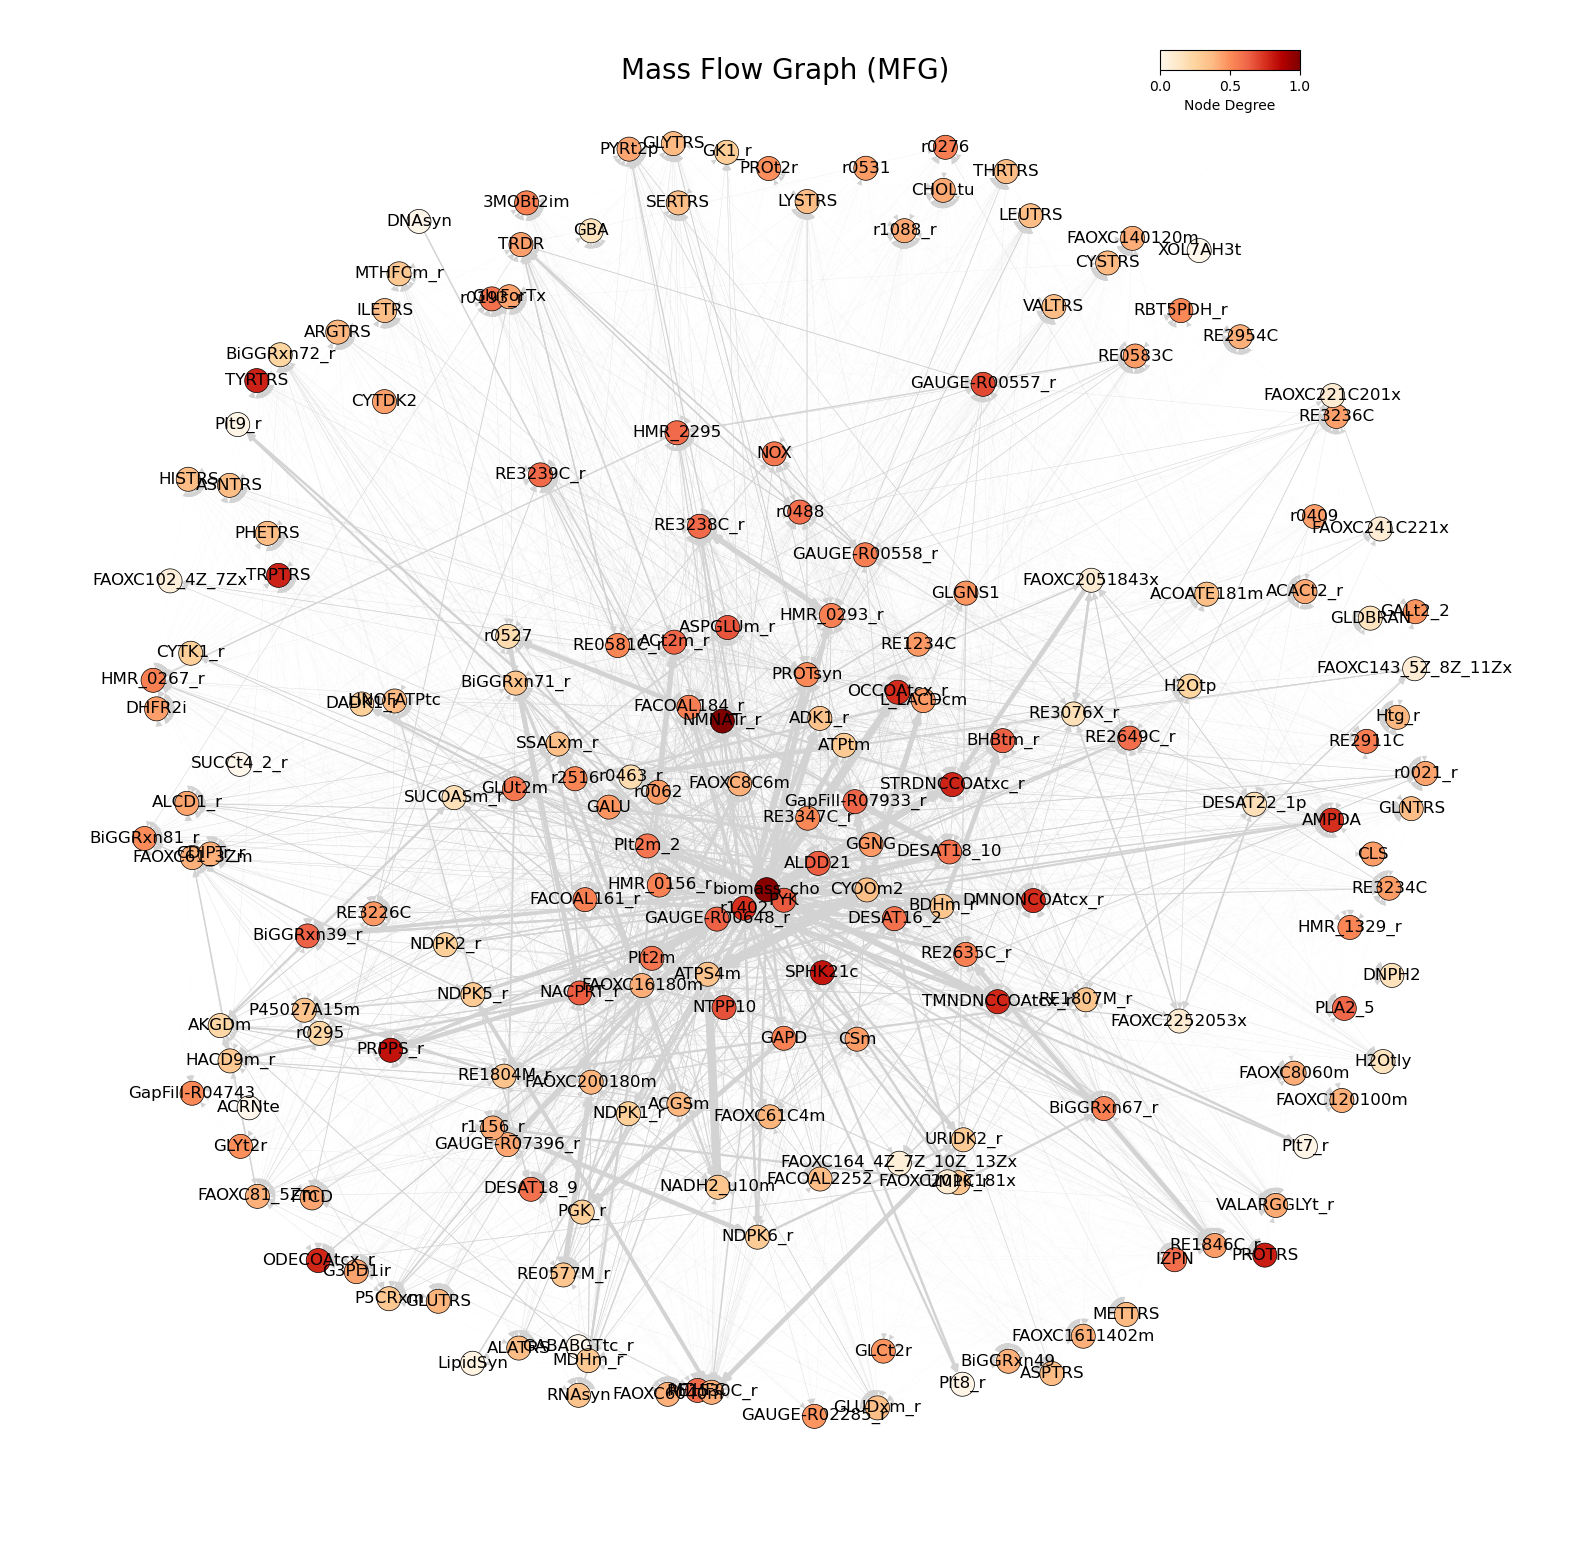

In [19]:
# Select which labels to display in the plot
reactions_to_keep = ["LipidSyn", "DNAsyn","RNAsyn", "PROTsyn", "biomass_cho"]
#reactions_to_keep = ["LipidSyn_prod", "DNAsyn_prod","RNAsyn_prod", "PROTsyn_prod", "biomass_cho_prod"]

# Convert D matrix into a graph
#M_biomass = M_list[0]
#M_biomass_producing = M_list[1]
G = nx.from_numpy_array(M_Matrix, create_using=nx.DiGraph)

# Create a subgraph containing only the nodes with a degree greater than min_degree
degrees = {node: val for (node, val) in G.degree()} # Calculate the degrees of each node
min_degree = 30 # Define the minimum degree for a node to be kept.
nodes_to_keep = [node for node, degree in degrees.items() if degree >= min_degree]

# Create a dictionary mapping node indices to reaction names for labeling
reaction_names = np.concatenate(([reaction.id for reaction in model.reactions],
                         [reaction.id + '_r' for reaction in model.reactions]))
mapping_reactions = {i: reaction_name for i, reaction_name in enumerate(reaction_names)}

indices_to_keep = [i for i, reaction_name in enumerate(reaction_names) if reaction_name in reactions_to_keep]
nodes_to_keep = list(set(nodes_to_keep).union(set(indices_to_keep)))
node_labels_filtered = {i: reaction_name for i, reaction_name in enumerate(reaction_names) if i in nodes_to_keep}

# Create a subgraph containing only the nodes with a degree greater than min_degree
G_filtered = G.subgraph(node_labels_filtered)

# Relabel the nodes in the filtered graph
G_filtered = nx.relabel_nodes(G_filtered, node_labels_filtered)

# Check if all nodes in node_labels_filtered are in G_filtered
missing_nodes = set(node_labels_filtered.values()) - set(G_filtered.nodes())
if missing_nodes:
    print(f"Nodes in node_labels_filtered but not in G_filtered: {missing_nodes}")


# Normalize weights for the edges of the nodes
weights = [G_filtered[u][v]['weight'] for u,v in G_filtered.edges()]
normalized_weights = [(w - min(weights)) / (max(weights) - min(weights)) * (7 - 0.001) + 0.001 for w in weights]

# Normalize the degrees for color mapping
degrees_filtered = [val for (node, val) in G_filtered.degree()]
normalized_degrees_filtered = [(d - min(degrees_filtered)) / (max(degrees_filtered) - min(degrees_filtered)) for d in degrees_filtered]

# Use a colormap to map normalized degrees to colors
cmap = plt.get_cmap('OrRd')  # Choose a colormap here
node_colors_filtered = [cmap(deg) for deg in normalized_degrees_filtered]

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 20))
pos_filtered = nx.spring_layout(G_filtered, k=4.5, iterations=50)
nx.draw(G_filtered, pos_filtered, width=normalized_weights, with_labels=True, node_color=node_colors_filtered, edge_color='lightgray', node_size=300, ax=ax, edgecolors='black', linewidths=0.5)
plt.title('Mass Flow Graph (MFG)', fontsize=20, y=0.95)

# Add a colorbar as the legend for node colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(normalized_degrees_filtered), vmax=max(normalized_degrees_filtered)))
sm.set_array([])
cbar_ax = fig.add_axes([0.7, 0.85, 0.07, 0.01])
cbar = plt.colorbar(sm, cax=cbar_ax, label='Node Degree', orientation='horizontal')

#nx.write_graphml(G, "../Networks/mass_flow_network.graphml") #save the object G
plt.savefig('../Networks/mass_flow_graph.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
# Select which labels to display in the plot
#reactions_to_keep = ["LipidSyn", "DNAsyn","RNAsyn", "PROTsyn", "biomass_cho"]
reactions_to_keep = ["LipidSyn_prod", "DNAsyn_prod","RNAsyn_prod", "PROTsyn_prod", "biomass_cho_prod"]

# Convert D matrix into a graph
M_biomass = M_list[0]
M_biomass_producing = M_list[1]
G = nx.from_numpy_array(M_biomass_producing, create_using=nx.DiGraph)

# Create a subgraph containing only the nodes with a degree greater than min_degree
degrees = {node: val for (node, val) in G.degree()} # Calculate the degrees of each node
min_degree = 30 # Define the minimum degree for a node to be kept.
nodes_to_keep = [node for node, degree in degrees.items() if degree >= min_degree]

# Create a dictionary mapping node indices to reaction names for labeling
reaction_names = np.concatenate(([reaction.id for reaction in model.reactions],
                         [reaction.id + '_r' for reaction in model.reactions]))

if reactions_to_keep:
    indices_to_keep = [i for i, reaction_name in enumerate(reaction_names) if reaction_name in reactions_to_keep]
    nodes_to_keep = list(set(nodes_to_keep).union(set(indices_to_keep)))
    node_labels_filtered = {i: reaction_name for i, reaction_name in enumerate(reaction_names) if i in nodes_to_keep and reaction_name in reactions_to_keep}
else:
    node_labels_filtered = {i: reaction_name for i, reaction_name in enumerate(reaction_names) if i in nodes_to_keep}

G_filtered = G.subgraph(nodes_to_keep)
# Normalize weights for the edges of the nodes
weights = [G_filtered[u][v]['weight'] for u,v in G_filtered.edges()]
normalized_weights = [(w - min(weights)) / (max(weights) - min(weights)) * (7 - 0.001) + 0.001 for w in weights]

# Normalize the degrees for color mapping
degrees_filtered = [val for (node, val) in G_filtered.degree()]
normalized_degrees_filtered = [(d - min(degrees_filtered)) / (max(degrees_filtered) - min(degrees_filtered)) for d in degrees_filtered]

# Use a colormap to map normalized degrees to colors
cmap = plt.get_cmap('OrRd')  # Choose a colormap here
node_colors_filtered = [cmap(deg) for deg in normalized_degrees_filtered]

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 20))
pos_filtered = nx.spring_layout(G_filtered, k=2.9)
nx.draw(G_filtered, pos_filtered, width=normalized_weights, node_color=node_colors_filtered, edge_color='lightgray', node_size=300, ax=ax, edgecolors='black', linewidths=0.5)
plt.title('Mass Flow Graph (MFG)', fontsize=20, y=0.95)

# Labels
label_pos_filtered = {node: (x + 0.015, y + 0.015) for node, (x, y) in pos_filtered.items()}
nx.draw_networkx_labels(G_filtered, label_pos_filtered, labels=node_labels_filtered, font_size=10, ax=ax)

# Add a colorbar as the legend for node colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(normalized_degrees_filtered), vmax=max(normalized_degrees_filtered)))
sm.set_array([])
cbar_ax = fig.add_axes([0.7, 0.85, 0.07, 0.01])
cbar = plt.colorbar(sm, cax=cbar_ax, label='Node Degree', orientation='horizontal')

nx.write_graphml(G, "../Networks/mass_flow_network.graphml") #save the object G
plt.savefig('../Networks/mass_flow_graph_prod.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

### 3.6 Word Cloud Plot for Metabolites Frecuencies in Pagerank

In [20]:
# Calculate and store PageRank
PageRank = []
G = nx.from_numpy_array(M_Matrix, create_using=nx.DiGraph)
pr = nx.pagerank(G)
PageRank.append(pr)

In [25]:
# Post-processing of PageRank
S = cobra.util.array.create_stoichiometric_matrix(model)
n, m = S.shape
df = pd.DataFrame(PageRank)
PageRank = df.values
PageRank = np.array(PageRank).T
PageRankRxns = PageRank[:m, :]
PageRankRxns_back = PageRank[m:, :]

for i in range(m):
    for j in range(PageRankRxns.shape[1]):
        if PageRankRxns_back[i, j] > PageRankRxns[i, j]:
            PageRankRxns[i, j] = PageRankRxns_back[i, j]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
#row_sums = PageRankRxns.sum(axis=1)
df = pd.DataFrame()
for i,n in enumerate(objectives):
    sorted_indices = np.argsort(PageRankRxns[:,i])
    rxns_list = []
    values_list = []
    for s in sorted_indices[::-1]:
        rxns_list.append(model.reactions[s].id)
        values_list.append(PageRankRxns[s,i])
    
    df[n] = pd.Series(rxns_list)
    df[f'values_{n}'] = pd.Series(values_list)

In [ ]:
for i,v in df.iterrows():
    print(v['biomass_producing'],v['values_biomass_producing'])

In [ ]:
mets_list = []
for rxn in df['biomass'][df['values_biomass'] > 0.0000412]:
    r = model.reactions.get_by_id(rxn)
    mets = r.metabolites
    for met in mets:
        mets_list.append(met.id)
        
for rxn in df['biomass_producing'][df['values_biomass_producing'] > 0.0000412]:
    r = model.reactions.get_by_id(rxn)
    mets = r.metabolites
    for met in mets:
        mets_list.append(met.id)

In [ ]:
# Count the frequencies of each metabolite
mets_freq = Counter(mets_list)
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('h2o_')} #eliminate water
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('h2o2_')} #eliminate peroxide
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('co2_')} #eliminate carbon dioxide
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('nh4_')} #eliminate amonium
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('h_')} #eliminate protons
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('atp_')} #eliminate atp
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('adp_')} #eliminate adp
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('amp_')} #eliminate amp
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('nad_')} #eliminate nad
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('nadh_')} #eliminate nadh
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('nadp_')} #eliminate nadp
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('nadph_')} #eliminate nadph
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('na1_')} #eliminate Sodium
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('coa_')} #eliminate CoA
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('accoa_')} #eliminate Acetyl-CoA
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('pi_')} #eliminate phosphate
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('ppi_')} #eliminate phosphate
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('fadh2_')} #eliminate FADH
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('fad_')} #eliminate FAD
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('o2_')} #eliminate Oxigen

# Create a circular mask
radius = 500  # you can change to the size you need
circle_img = np.zeros((2*radius, 2*radius), np.uint8)
rr, cc = draw.disk((radius, radius), radius)
circle_img[rr, cc] = 1

# Create the word cloud
wordcloud = WordCloud(width = 1000, height = 500, mask=circle_img, background_color="rgba(255, 255, 255, 0)", mode="RGBA").generate_from_frequencies(mets_freq)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.savefig('wordcloud.png', bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [ ]:
counter=0
for met in mets_freq:
    print(met,mets_freq[met])
    counter+=1
    
print(counter)

In [ ]:
#Store the metabolites and their frequencies in a .txt file

with open('metabolites.txt', 'w') as f:
    for i, j in enumerate(mets_freq):
        print(j,'Freq:',mets_freq[j], file=f)

## 4. Identification of duplicates through Chemical Formulas <a id='formulas'></a>

In [ ]:
# Chemical Formula
from cobra.io import read_sbml_model
model = read_sbml_model("iCHOv3_CHO_23052023.xml")

import pandas as pd
data = []

for m in model.metabolites:
    m.name = m.formula
for r in model.reactions:
    if r not in model.exchanges:
        print(r)
        reaction_id = r.id
        reaction_name = r.name
        reaction_formula = r.build_reaction_string(use_metabolite_names=True)
        data.append([reaction_id, reaction_name, reaction_formula])
df = pd.DataFrame(data, columns=['ID', 'Name', 'Reaction'])
df

In [ ]:
for m in model.metabolites:
    m.name = m.formula
for r in model.reactions:
    if r not in model.exchanges:
        reaction_id = r.id
        reaction_name = r.name
        reaction_formula = r.build_reaction_string(use_metabolite_names=True)
        data.append([reaction_id, reaction_name, reaction_formula])
df = pd.DataFrame(data, columns=['ID', 'Name', 'Reaction'])
df

In [ ]:
subset_duplicates = df[df.duplicated(subset='Reaction', keep=False)].reset_index(drop=True)
subset_duplicates = subset_duplicates.sort_values(by=['Reaction'])
subset_duplicates.to_excel('Test.xlsx')

for index, n in enumerate(subset_duplicates['Reaction']):
    next_value = subset_duplicates['Reaction'][index + 1]
    if n == next_value:
        print(subset_duplicates['Name'][index])

        

### Duplicates identified

In [ ]:
print(model.metabolites.get_by_id('uppg1_c').name, model.metabolites.get_by_id('HC01609_c').name)
for r in model.metabolites.get_by_id('uppg1_c').reactions:
    print(r)
print('------')
for r in model.metabolites.get_by_id('HC01609_c').reactions:
    print(r)
# Based on reations HMR_4772 and GapFill-R04972, HC01609_c and uppg1_c  are the same 

In [ ]:
print(model.metabolites.get_by_id('HC02187_c').name, model.metabolites.get_by_id('triodthy_c').name)
for r in model.metabolites.get_by_id('HC02187_c').reactions:
    print(r)
print('------')
for r in model.metabolites.get_by_id('triodthy_c').reactions:
    print(r)
# Based on reations HMR_6834 and HMR_6826, triodthy_c and HC02187_c  are the same 